# Subgroup Robustness Grows on Trees (Experiments)
Here are some initial experiments corroborating the empirical observations from *Subgroup Robustness Grows on Trees*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

## Datasets
We'll run experiments on three datasets typically used in the fairness and robustness literature:

1. Adult (*medium*). $n = 499,350$ examples, $20$ features, sensitive groups: *Race* and *Sex*.
2. ACS Income (*large*) $n = 48,845$ examples, $14$ features, sensitive groups: *Race* and *Sex*.
3. Communities and Crime (*small*) $n = 1,994$ examples, $113$ features, sensitive groups: *Income Level* and *Race.*

We will also do experiments with a fourth synthetic dataset that has overlapping group structure.

### Adult Dataset
The Adult Dataset is a benchmark derived from 1994 US Census data. The task is to predict whether an individual's income
exceeds $50,000 (binary classification). Sensitive attributes are *Race* and *Sex*.

- *Race:* $\{\text{White}, \text{Asian-Pac-Islander}, \text{Amer-Indian-Eskimo}, \text{Other}, \text{Black} \}$
- *Sex:* $\{\text{Male}, \text{Female}\}$

The standard in the literature has been to simplify the groups for *Race* to $\text{White}$ and $\text{NotWhite}$.

In [2]:
# Adult Dataset
adult_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                "marital-status", "occupation", "relationship", "race", "sex",
                "capital-gain", "capital-loss", "hours-per-week", "native-country", 
                "income"]
adult_data = pd.read_csv("./datasets/adult/adult.data", header=None, names=adult_names, na_values=' ?')
adult_data = adult_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
adult_test = pd.read_csv("./datasets/adult/adult.test", header=None, names=adult_names, na_values=' ?')
adult_test = adult_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
dfs = [adult_data, adult_test]
adult_df = pd.concat(dfs)
adult_df = adult_df.dropna()
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
print("Adult Shape: {}".format(adult_df.shape))

# last column in adult has some textual discrepancy
adult_df = adult_df.replace(">50K.", ">50K")
adult_df = adult_df.replace("<=50K.", "<=50K")

# Split into X and y
X, y = adult_df.drop("income", axis=1), adult_df["income"]

# Select categorical and numerical features
cat_idx = X.select_dtypes(include=["object", "bool"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variable so we have classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples >=50k (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples <50k (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

Adult Shape: (45222, 15)
% examples >=50k (y=1): 24.78439697492371
% examples <50k (y=0): 75.21560302507629


In [3]:
# Prepend KFold validation
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from prepend.prepend_algo import prepend_algo
from sklearn.svm import SVC
from sklearn.metrics import zero_one_loss

def prepend_fit_score(X, y, train, test, model, loss, groups, params, score_metric):
	# convert index array into mask array for compatibility
	train_mask = np.zeros(len(y), dtype=bool)
	test_mask = np.zeros(len(y), dtype=bool)
	train_mask[train] = True
	test_mask[test] = True

	dec_list = prepend_algo(X[train_mask], y[train_mask], model, loss, groups, params, col_transf)
	y_pred = dec_list.predict(X[test_mask])
	score = score_metric(y[test_mask], y_pred)

	return score

def prepend_cross_val(X, y, model, loss, groups, params, cv, score_metric=accuracy_score, n_jobs=-1):
	parallel = Parallel(n_jobs=n_jobs)
	results = parallel(
		delayed(prepend_fit_score)(
			X, 
			y, 
			train, 
			test,
			model,
			loss,
			groups,
			params,
			score_metric
		)
		for train, test in cv.split(X, y)
	)

	return results

In [4]:
def produce_group_adult(race_val, sex_val):
    def f(x):
        return (x['race'] == race_val) & (x['sex'] == sex_val)
    def f_notwhite(x):
        return (x['race'] != 'White') & (x['sex'] == sex_val)
    
    if race_val == "NotWhite":
        return f_notwhite
    else:
        return f
    
def adult_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 'White') & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == race_val) & (df['sex'] == sex_val))

# define group functions
group_names_coarse = list()
groups_coarse = list()
group_indices_coarse = list()
race_gps_coarse = ["White", "NotWhite"]
race_gps_fine = ["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"]
sex_gps = ["Male", "Female"]
for race in race_gps_coarse:
    for sex in sex_gps:
        group_names_coarse.append((race, sex))
        groups_coarse.append(produce_group_adult(race, sex))
        group_indices_coarse.append(adult_gp_indices(X, race, sex)[0])

group_names_fine = list()
groups_fine = list()
group_indices_fine = list()
for race in race_gps_fine:
    for sex in sex_gps:
        group_names_fine.append((race, sex))
        groups_fine.append(produce_group_adult(race, sex))
        group_indices_fine.append(adult_gp_indices(X, race, sex)[0])

print("Group Names (Coarse): {}".format(group_names_coarse))
print("Group Names (Fine): {}".format(group_names_fine))

Group Names (Coarse): [('White', 'Male'), ('White', 'Female'), ('NotWhite', 'Male'), ('NotWhite', 'Female')]
Group Names (Fine): [('White', 'Male'), ('White', 'Female'), ('Asian-Pac-Islander', 'Male'), ('Asian-Pac-Islander', 'Female'), ('Amer-Indian-Eskimo', 'Male'), ('Amer-Indian-Eskimo', 'Female'), ('Other', 'Male'), ('Other', 'Female'), ('Black', 'Male'), ('Black', 'Female')]


## Fit and Evaluate Models

In [5]:
def prepend_cross_val(X, y, model, loss, groups, params, cv, score_metric=accuracy_score, n_jobs=-1):
	parallel = Parallel(n_jobs=n_jobs)
	results = parallel(
		delayed(prepend_fit_score)(
			X, 
			y, 
			train, 
			test,
			model,
			loss,
			groups,
			params,
			score_metric
		)
		for train, test in cv.split(X, y)
	)

	return results

In [6]:
# Cross validation code for baseline models and tree models

def avg_gp_scores(X, y,  train, test, model, group_funcs):
    # convert index array into mask array for compatibility
    train_mask = np.zeros(len(y), dtype=bool)
    test_mask = np.zeros(len(y), dtype=bool)
    train_mask[train] = True
    test_mask[test] = True
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]

    # find indices of groups for evaluation
    group_masks = list()
    for g in group_funcs:
        g_indices = np.where(g(X_test))
        g_mask = np.zeros(len(X_test), dtype=bool)
        g_mask[g_indices] = True
        group_masks.append(g_mask)

    # fit and evaluate model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    avg_acc = accuracy_score(y_test, y_pred)
    group_accs = list()
    for g in group_masks:
        y_pred = model.predict(X_test[g])
        g_acc = accuracy_score(y_test[g], y_pred)
        group_accs.append(g_acc)

    return avg_acc, group_accs

def avg_gp_scores(X, y,  train, test, model, group_funcs, prepend_params=None):
    # convert index array into mask array for compatibility
    train_mask = np.zeros(len(y), dtype=bool)
    test_mask = np.zeros(len(y), dtype=bool)
    train_mask[train] = True
    test_mask[test] = True
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]

    # find indices of groups for evaluation
    group_masks = list()
    for g in group_funcs:
        g_indices = np.where(g(X_test))
        g_mask = np.zeros(len(X_test), dtype=bool)
        g_mask[g_indices] = True
        group_masks.append(g_mask)
        
    # fit and evaluate model
    if prepend_params:
        dec_list = prepend_algo(X_train, y_train, model, prepend_params['loss'], 
                                group_funcs, prepend_params['params'], 
                                prepend_params['transf'], verbose=True)
        y_pred = dec_list.predict(X_test)
        print(len(dec_list.groups))
        avg_acc = accuracy_score(y_test, y_pred)
        group_accs = list()
        for g in group_masks:
            y_pred = dec_list.predict(X_test[g])
            g_acc = accuracy_score(y_test[g], y_pred)
            group_accs.append(g_acc)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        avg_acc = accuracy_score(y_test, y_pred)
        group_accs = list()
        for g in group_masks:
            y_pred = model.predict(X_test[g])
            g_acc = accuracy_score(y_test[g], y_pred)
            group_accs.append(g_acc)

    return avg_acc, group_accs

def my_cross_val(X, y, model, group_funcs, cv, prepend_params=None, n_jobs=-1):
    parallel = Parallel(n_jobs=n_jobs)

    if prepend_params:
        results = parallel(
            delayed(avg_gp_scores)(
                X, y, train, test, model, group_funcs, 
                prepend_params=prepend_params
            )
            for train, test, in cv.split(X, y)
        )
    else:
        results = parallel(
            delayed(avg_gp_scores)(
                X, y, train, test, model, group_funcs
            )
            for train, test in cv.split(X, y)
        )

    k_avg_accs = list()
    k_group_accs = [list() for _ in group_funcs]
    for avg_acc, group_accs in results:
        k_avg_accs.append(avg_acc)
        for i in range(len(group_funcs)):
            k_group_accs[i].append(group_accs[i])

    return k_avg_accs, k_group_accs

In [7]:
# test out cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
model = LogisticRegression(max_iter=500)
pipe = Pipeline([('col_transf', col_transf), ('logreg', model)])
avg_accs, group_accs = my_cross_val(X, y, pipe, groups_coarse, cv)
print(avg_accs)
print(group_accs)

[0.8412382531785517, 0.8452183526810393, 0.8484077841662981, 0.8479655019902698, 0.8534940291906237]
[[0.7959599703484063, 0.8052999631947, 0.8083732939874585, 0.8002983404810741, 0.81313598519889], [0.9202172096908939, 0.9246252676659529, 0.9108742004264392, 0.9238056013179572, 0.9202015959680806], [0.8405797101449275, 0.8146067415730337, 0.8741450068399452, 0.8656934306569343, 0.8606676342525399], [0.9398230088495575, 0.9397163120567376, 0.9432234432234432, 0.9524647887323944, 0.9490333919156415]]


In [8]:
# test out cross validation for prepend
prepend_params = {
    'loss': zero_one_loss,
    'params': {
        'max_iter' : 500
    },
    'transf': col_transf
}
avg_accs, group_accs = my_cross_val(X, y, LogisticRegression, groups_coarse, cv, prepend_params)
print(avg_accs)
print(group_accs)

fitting for group 0
group 0 has 21598 examples.
fitting for group 0
group 0 has 21615 examples.
fitting for group 1
group 1 has 9538 examples.
fitting for group 1
group 1 has 9502 examples.
fitting for group 0
group 0 has 21624 examples.
fitting for group 0
group 0 has 21586 examples.
fitting for group 2
group 2 has 2776 examples.
fitting for group 2
group 2 has 2818 examples.
fitting for group 3
group 3 has 2266 examples.
fitting for group 3
group 3 has 2243 examples.
fitting for group 0
group 0 has 21657 examples.
1
1
fitting for group 1
group 1 has 9489 examples.
fitting for group 1
group 1 has 9548 examples.
fitting for group 2
group 2 has 2817 examples.
fitting for group 3
group 3 has 2247 examples.
fitting for group 1
group 1 has 9455 examples.
fitting for group 2
group 2 has 2795 examples.
fitting for group 3
group 3 has 2248 examples.
fitting for group 2
group 2 has 2822 examples.
fitting for group 3
group 3 has 2244 examples.
Iteration t=0: prepended group 0
old errors=[0.1921

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

# find indices of groups for evaluation
group_masks = list()
group_masks.append([True] * y.shape[0])
for g in groups_coarse:
    g_indices = np.where(g(X))
    g_mask = np.zeros(len(X), dtype=bool)
    g_mask[g_indices] = True
    group_masks.append(g_mask)
group_names_coarse.insert(0, "ALL")

# do train-test split
X_transf = col_transf.fit_transform(X)
print(X_transf.shape)
splits = train_test_split(*tuple([X, y] + group_masks), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]
group_train = splits[4::2]
group_test = splits[5::2]
num_groups = 5

num_group_train = {}
num_group_test = {}
print('Group\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names_coarse[g]))

(45222, 104)
Group	train	test
0 (ALL)	36177	9045
1 (('White', 'Male'))	21603	5417
2 (('White', 'Female'))	9520	2363
3 (('NotWhite', 'Male'))	2815	692
4 (('NotWhite', 'Female'))	2239	573


In [21]:
models = {}
yhats = {}
test_err = {}
for g in range(num_groups):
    models[g] = LogisticRegressionCV(cv=3, max_iter=500)
    #models[g] = DecisionTreeClassifier(random_state=0)
    #models[g] = RandomForestClassifier(random_state=0)
    models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
    yhats[g] = models[g].predict(col_transf.transform(X_test))
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g],np.sqrt(2. * test_err[g] * (1.0 - test_err[g]) / num_group_test[g]), num_group_test[g], group_names_coarse[g]))


group 0 (ALL): 0.14892205638474296 (+/-0.005293889747457745; n=9045)
group 1 (('White', 'Male')): 0.19198818534244047 (+/-0.0075680098284835315; n=5417)
group 2 (('White', 'Female')): 0.07829030892932713 (+/-0.00781509420174876; n=2363)
group 3 (('NotWhite', 'Male')): 0.13872832369942195 (+/-0.0185829476110788; n=692)
group 4 (('NotWhite', 'Female')): 0.06108202443280977 (+/-0.014148429167305701; n=573)


In [22]:
f = [0]
#epsilon = 0.01
epsilon = 0

H_train = {}
H_test = {}
H_train_err = {}
for g in range(num_groups):
    H_train[g] = models[g].predict(col_transf.transform(X_train))
    H_test[g] = models[g].predict(col_transf.transform(X_test))
    H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
F_train = H_train[0].copy()
F_test = H_test[0].copy()
F_train_err = {}
for g in range(num_groups):
    F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
while True:
    #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
    scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
    g = np.argmin(scores)
    if scores[g] < 0.:
        f.insert(0,g) # prepend g to the list f
        F_train[group_train[g]] = H_train[g][group_train[g]]
        F_test[group_test[g]] = H_test[g][group_test[g]]
        for g in range(num_groups):
            F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    else:
        break

In [23]:
print([group_names_coarse[g] for g in f])

[('White', 'Male'), ('White', 'Female'), ('NotWhite', 'Female'), ('NotWhite', 'Male'), 'ALL']


In [24]:
F_test_err = {}
for g in range(num_groups):
    F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], np.sqrt(2. * F_test_err[g] * (1.0 - F_test_err[g]) / num_group_test[g]), num_group_test[g], group_names_coarse[g]))

group 0 (ALL): 0.14991708126036485 (+/-0.005308440039837308; n=9045)
group 1 (('White', 'Male')): 0.19198818534244047 (+/-0.0075680098284835315; n=5417)
group 2 (('White', 'Female')): 0.07829030892932713 (+/-0.00781509420174876; n=2363)
group 3 (('NotWhite', 'Male')): 0.13872832369942195 (+/-0.0185829476110788; n=692)
group 4 (('NotWhite', 'Female')): 0.06108202443280977 (+/-0.014148429167305701; n=573)


In [25]:
for g in range(num_groups):
    yhats[g] = models[0].predict(col_transf.transform(X_test))
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g],np.sqrt(2. * test_err[g] * (1.0 - test_err[g]) / num_group_test[g]), num_group_test[g], group_names_coarse[g]))

group 0 (ALL): 0.14892205638474296 (+/-0.005293889747457745; n=9045)
group 1 (('White', 'Male')): 0.19254199741554365 (+/-0.0075763196231075644; n=5417)
group 2 (('White', 'Female')): 0.07405840033855268 (+/-0.007618370656392775; n=2363)
group 3 (('NotWhite', 'Male')): 0.1416184971098266 (+/-0.018743993133075364; n=692)
group 4 (('NotWhite', 'Female')): 0.05410122164048865 (+/-0.013364833574195843; n=573)


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def all_accs(X, y, model):
	# define evaluation procedure
	cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

def group_accs(X, y, model, gp_indices):
    # define evaluation procedure
    cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    
    gp_scores = []
    for indices in gp_indices:
        scores = cross_val_score(model, X.iloc[indices], y[indices], 
                                scoring='accuracy', cv=cv, n_jobs=-1)
        gp_scores.append(scores)

    return gp_scores

def prepend_group_accs(X, y, model, gp_indices, loss, groups, params):
    # define evaluation procedure
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    gp_scores = []
    for indices in gp_indices:
        scores = prepend_cross_val(X.iloc[indices], y[indices], model, loss, groups, params, skf)
        gp_scores.append(scores)

    return gp_scores

In [14]:
def model_suite():
    models = []
    names = []

    # Decision Tree
    models.append(DecisionTreeClassifier())
    names.append("Decision Tree (single, CART)")

    # SVM
    models.append(SVC(gamma="scale"))
    names.append("SVM")

    # Logistic Regression
    models.append(LogisticRegression(max_iter=500))
    names.append("Logistic Regression")

    # Random Forest
    num_trees = [64, 128, 256, 512, 1024]
    for n in num_trees:
        models.append(RandomForestClassifier(n_estimators=n))
        names.append("Random Forests ({} trees)".format(n))
    
    # Gradient Boosting
    for n in num_trees:
        models.append(GradientBoostingClassifier(n_estimators=n))
        names.append("Gradient Boosting ({} trees)".format(n))

    return models, names

models, model_names = model_suite()
results = list() # list of dictionaries of 6 scores

'''
for i in range(len(models)):
    pipe = Pipeline([('col_transf', col_transf), (model_names[i], models[i])])

    # Evaluate model per group
    print("Model: {}".format(model_names[i]))
    mean_gp_scores = []
    group_scores = group_accs(X, y, pipe, group_indices_coarse)
    for group_score in group_scores:
        mean_gp_scores.append(np.mean(group_score))
    worst_gp_score = min(mean_gp_scores)
    all_scores = np.mean(all_accs(X, y, pipe))
    for j in range(len(mean_gp_scores)):
        print("Group ({}) Accuracy: {}".format(group_names_coarse[j], mean_gp_scores[j]))
    print("Worst Group Accuracy: {}".format(worst_gp_score))
    print("Overall Accuracy: {}".format(all_scores))
    print()

    # Save results
    result = dict()
    result['group_accs'] = mean_gp_scores
    result['worst_group'] = worst_gp_score
    result['avg_acc'] = all_scores
    results.append(result)
'''

'\nfor i in range(len(models)):\n    pipe = Pipeline([(\'col_transf\', col_transf), (model_names[i], models[i])])\n\n    # Evaluate model per group\n    print("Model: {}".format(model_names[i]))\n    mean_gp_scores = []\n    group_scores = group_accs(X, y, pipe, group_indices_coarse)\n    for group_score in group_scores:\n        mean_gp_scores.append(np.mean(group_score))\n    worst_gp_score = min(mean_gp_scores)\n    all_scores = np.mean(all_accs(X, y, pipe))\n    for j in range(len(mean_gp_scores)):\n        print("Group ({}) Accuracy: {}".format(group_names_coarse[j], mean_gp_scores[j]))\n    print("Worst Group Accuracy: {}".format(worst_gp_score))\n    print("Overall Accuracy: {}".format(all_scores))\n    print()\n\n    # Save results\n    result = dict()\n    result[\'group_accs\'] = mean_gp_scores\n    result[\'worst_group\'] = worst_gp_score\n    result[\'avg_acc\'] = all_scores\n    results.append(result)\n'

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (13,) and arg 1 with shape (0,).

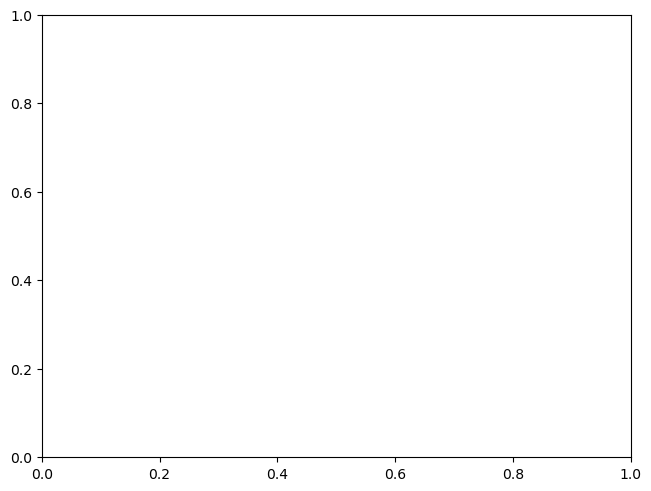

In [15]:
# Plot these initial results
x = np.arange(len(model_names))
width = 0.25
multiplier = 0

accuracies = {
    #'g0_acc': [],
    #'g1_acc': [],
    #'g2_acc': [],
    #'g3_acc': [],
    'worst_gp_acc': [],
    'avg_acc': []
}
for result in results:
    #accuracies['g0_acc'].append(result['group_accs'][0])
    #accuracies['g1_acc'].append(result['group_accs'][1])
    #accuracies['g2_acc'].append(result['group_accs'][2])
    #accuracies['g3_acc'].append(result['group_accs'][3])
    accuracies['worst_gp_acc'].append(result['worst_group'])
    accuracies['avg_acc'].append(result['avg_acc'])

fig, ax = plt.subplots(layout='constrained')
for acc, val in accuracies.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, val, width, label=acc)
    multiplier += 1

ax.set_ylabel("accuracy")
ax.set_xticks(x + width, model_names, rotation=90)
ax.legend(loc='best', bbox_to_anchor=(0.5, 1), ncols=3)
plt.show()

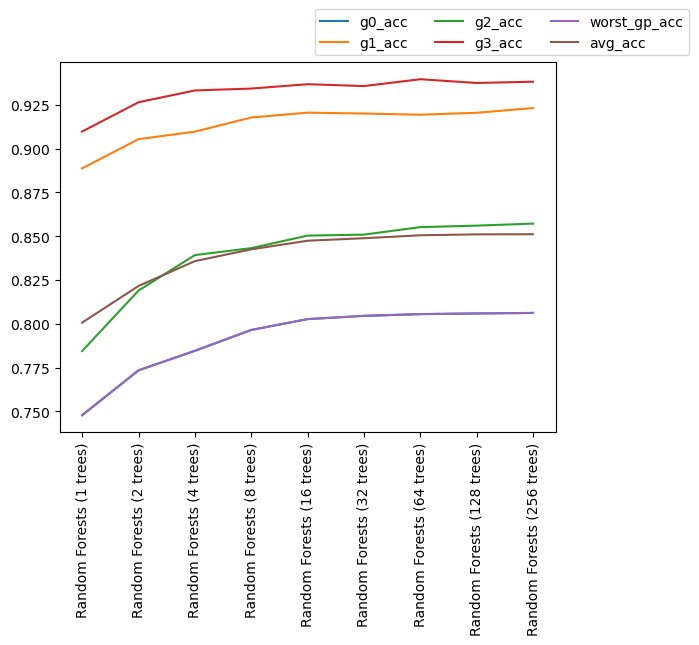

In [ ]:
# Plot only for Random Forests with different n_estimators
rf_accuracies = {
    'g0_acc': [],
    'g1_acc': [],
    'g2_acc': [],
    'g3_acc': [],
    'worst_gp_acc': [],
    'avg_acc': []
}
rf_names = model_names[3:12]
rf_results = results[3:12]

for result in rf_results:
    rf_accuracies['g0_acc'].append(result['group_accs'][0])
    rf_accuracies['g1_acc'].append(result['group_accs'][1])
    rf_accuracies['g2_acc'].append(result['group_accs'][2])
    rf_accuracies['g3_acc'].append(result['group_accs'][3])
    rf_accuracies['worst_gp_acc'].append(result['worst_group'])
    rf_accuracies['avg_acc'].append(result['avg_acc'])

for acc, val in rf_accuracies.items():
    plt.plot(rf_names, val, label=acc)

plt.xticks(rf_names, rotation=90)
plt.legend(loc='best', bbox_to_anchor=(0.5, 1), ncols=3)
plt.show()

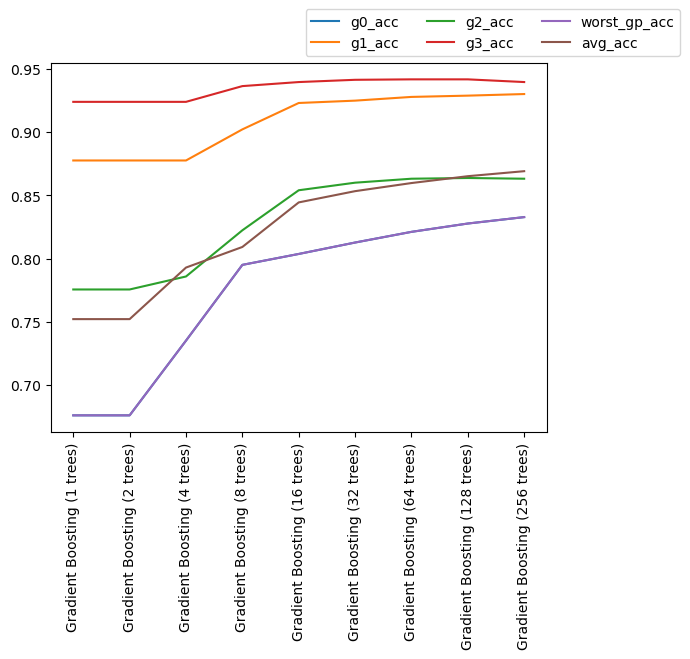

In [ ]:
# Plot only for Gradient Boosting with different n_estimators
gb_accuracies = {
    'g0_acc': [],
    'g1_acc': [],
    'g2_acc': [],
    'g3_acc': [],
    'worst_gp_acc': [],
    'avg_acc': []
}
gb_names = model_names[12:]
gb_results = results[12:]

for result in gb_results:
    gb_accuracies['g0_acc'].append(result['group_accs'][0])
    gb_accuracies['g1_acc'].append(result['group_accs'][1])
    gb_accuracies['g2_acc'].append(result['group_accs'][2])
    gb_accuracies['g3_acc'].append(result['group_accs'][3])
    gb_accuracies['worst_gp_acc'].append(result['worst_group'])
    gb_accuracies['avg_acc'].append(result['avg_acc'])

for acc, val in gb_accuracies.items():
    plt.plot(gb_names, val, label=acc)

plt.xticks(gb_names, rotation=90)
plt.legend(loc='best', bbox_to_anchor=(0.5, 1), ncols=3)
plt.show()